# Description

Runs gaussian mixture model on the z_score_std version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 60000

## Input data

In [6]:
INPUT_SUBSET = "z_score_std"

In [7]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [8]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

## Clustering

In [9]:
from sklearn.mixture import GaussianMixture

In [10]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [11]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["N_INIT"] = 10
CLUSTERING_OPTIONS["COVARIANCE_TYPE"] = "full"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 60,
 'N_REPS_PER_K': 5,
 'N_INIT': 10,
 'COVARIANCE_TYPE': 'full'}

In [12]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = GaussianMixture(
            n_components=k,
            n_init=CLUSTERING_OPTIONS["N_INIT"],
            covariance_type=CLUSTERING_OPTIONS["COVARIANCE_TYPE"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [13]:
display(len(CLUSTERERS))

295

In [14]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('GaussianMixture #0',
 GaussianMixture(n_components=2, n_init=10, random_state=60000))

('GaussianMixture #1',
 GaussianMixture(n_components=2, n_init=10, random_state=60001))

In [15]:
clustering_method_name = method_name
display(clustering_method_name)

'GaussianMixture'

## Output directory

In [16]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_RUNS_DIR"],
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [17]:
data = pd.read_pickle(input_filepath)

In [18]:
data.shape

(3749, 987)

In [19]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [20]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [21]:
from clustering.ensemble import generate_ensemble

In [22]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

  0%|          | 0/295 [00:00<?, ?it/s]

  0%|          | 1/295 [00:10<49:55, 10.19s/it]

  1%|          | 2/295 [00:20<49:48, 10.20s/it]

  1%|          | 3/295 [00:30<49:43, 10.22s/it]

  1%|▏         | 4/295 [00:40<49:38, 10.24s/it]

  2%|▏         | 5/295 [00:51<49:23, 10.22s/it]

  2%|▏         | 6/295 [01:05<55:25, 11.51s/it]

  2%|▏         | 7/295 [01:20<59:43, 12.44s/it]

  3%|▎         | 8/295 [01:34<1:02:38, 13.09s/it]

  3%|▎         | 9/295 [01:49<1:04:35, 13.55s/it]

  3%|▎         | 10/295 [02:04<1:05:49, 13.86s/it]

  4%|▎         | 11/295 [02:23<1:13:20, 15.50s/it]

  4%|▍         | 12/295 [02:42<1:18:16, 16.60s/it]

  4%|▍         | 13/295 [03:01<1:21:22, 17.31s/it]

  5%|▍         | 14/295 [03:20<1:23:49, 17.90s/it]

  5%|▌         | 15/295 [03:40<1:25:33, 18.33s/it]

  5%|▌         | 16/295 [04:05<1:35:05, 20.45s/it]

  6%|▌         | 17/295 [04:29<1:40:10, 21.62s/it]

  6%|▌         | 18/295 [04:54<1:43:29, 22.42s/it]

  6%|▋         | 19/295 [05:19<1:46:43, 23.20s/it]

  7%|▋         | 20/295 [05:43<1:47:31, 23.46s/it]

  7%|▋         | 21/295 [06:13<1:56:54, 25.60s/it]

  7%|▋         | 22/295 [06:42<2:00:28, 26.48s/it]

  8%|▊         | 23/295 [07:11<2:04:00, 27.36s/it]

  8%|▊         | 24/295 [07:41<2:06:16, 27.96s/it]

  8%|▊         | 25/295 [08:10<2:07:16, 28.28s/it]

  9%|▉         | 26/295 [08:43<2:13:40, 29.81s/it]

  9%|▉         | 27/295 [09:19<2:21:22, 31.65s/it]

  9%|▉         | 28/295 [09:53<2:23:28, 32.24s/it]

 10%|▉         | 29/295 [10:26<2:24:39, 32.63s/it]

 10%|█         | 30/295 [11:03<2:29:16, 33.80s/it]

 11%|█         | 31/295 [11:40<2:33:28, 34.88s/it]

 11%|█         | 32/295 [12:18<2:36:56, 35.80s/it]

 11%|█         | 33/295 [12:56<2:39:34, 36.54s/it]

 12%|█▏        | 34/295 [13:34<2:40:32, 36.91s/it]

 12%|█▏        | 35/295 [14:12<2:41:15, 37.21s/it]

 12%|█▏        | 36/295 [14:54<2:46:57, 38.68s/it]

 13%|█▎        | 37/295 [15:36<2:50:30, 39.65s/it]

 13%|█▎        | 38/295 [16:18<2:52:37, 40.30s/it]

 13%|█▎        | 39/295 [17:00<2:54:08, 40.81s/it]

 14%|█▎        | 40/295 [17:42<2:55:23, 41.27s/it]

 14%|█▍        | 41/295 [18:28<3:00:56, 42.74s/it]

 14%|█▍        | 42/295 [19:14<3:04:24, 43.73s/it]

 15%|█▍        | 43/295 [20:01<3:07:03, 44.54s/it]

 15%|█▍        | 44/295 [20:47<3:08:30, 45.06s/it]

 15%|█▌        | 45/295 [21:34<3:09:42, 45.53s/it]

 16%|█▌        | 46/295 [22:24<3:15:15, 47.05s/it]

 16%|█▌        | 47/295 [23:15<3:18:44, 48.08s/it]

 16%|█▋        | 48/295 [24:05<3:21:02, 48.84s/it]

 17%|█▋        | 49/295 [24:57<3:22:59, 49.51s/it]

 17%|█▋        | 50/295 [25:47<3:23:54, 49.94s/it]

 17%|█▋        | 51/295 [26:43<3:29:39, 51.56s/it]

 18%|█▊        | 52/295 [27:38<3:33:07, 52.62s/it]

 18%|█▊        | 53/295 [28:33<3:34:55, 53.29s/it]

 18%|█▊        | 54/295 [29:28<3:36:21, 53.87s/it]

 19%|█▊        | 55/295 [30:23<3:37:17, 54.32s/it]

 19%|█▉        | 56/295 [31:23<3:42:47, 55.93s/it]

 19%|█▉        | 57/295 [32:23<3:46:48, 57.18s/it]

 20%|█▉        | 58/295 [33:23<3:48:50, 57.93s/it]

 20%|██        | 59/295 [34:22<3:49:50, 58.44s/it]

 20%|██        | 60/295 [35:22<3:50:12, 58.78s/it]

 21%|██        | 61/295 [36:26<3:55:21, 60.35s/it]

 21%|██        | 62/295 [37:30<3:58:52, 61.51s/it]

 21%|██▏       | 63/295 [38:34<4:00:50, 62.29s/it]

 22%|██▏       | 64/295 [39:39<4:02:01, 62.86s/it]

 22%|██▏       | 65/295 [40:43<4:02:20, 63.22s/it]

 22%|██▏       | 66/295 [41:51<4:07:27, 64.84s/it]

 23%|██▎       | 67/295 [43:00<4:10:35, 65.95s/it]

 23%|██▎       | 68/295 [44:08<4:12:41, 66.79s/it]

 23%|██▎       | 69/295 [45:17<4:13:02, 67.18s/it]

 24%|██▎       | 70/295 [46:25<4:13:18, 67.55s/it]

 24%|██▍       | 71/295 [47:39<4:19:02, 69.38s/it]

 24%|██▍       | 72/295 [48:52<4:22:16, 70.57s/it]

 25%|██▍       | 73/295 [50:05<4:24:08, 71.39s/it]

 25%|██▌       | 74/295 [51:19<4:25:26, 72.06s/it]

 25%|██▌       | 75/295 [52:32<4:25:36, 72.44s/it]

 26%|██▌       | 76/295 [53:50<4:29:48, 73.92s/it]

 26%|██▌       | 77/295 [55:07<4:32:28, 74.99s/it]

 26%|██▋       | 78/295 [56:25<4:34:02, 75.77s/it]

 27%|██▋       | 79/295 [57:42<4:34:37, 76.28s/it]

 27%|██▋       | 80/295 [59:00<4:34:29, 76.60s/it]

 27%|██▋       | 81/295 [1:00:21<4:38:47, 78.17s/it]

 28%|██▊       | 82/295 [1:01:44<4:42:03, 79.46s/it]

 28%|██▊       | 83/295 [1:03:06<4:43:32, 80.25s/it]

 28%|██▊       | 84/295 [1:04:28<4:43:47, 80.70s/it]

 29%|██▉       | 85/295 [1:05:50<4:43:45, 81.07s/it]

 29%|██▉       | 86/295 [1:07:16<4:47:37, 82.57s/it]

 29%|██▉       | 87/295 [1:08:42<4:50:15, 83.73s/it]

 30%|██▉       | 88/295 [1:10:09<4:52:08, 84.68s/it]

 30%|███       | 89/295 [1:11:35<4:52:17, 85.13s/it]

 31%|███       | 90/295 [1:13:01<4:51:50, 85.42s/it]

 31%|███       | 91/295 [1:14:32<4:56:19, 87.15s/it]

 31%|███       | 92/295 [1:16:04<4:58:56, 88.36s/it]

 32%|███▏      | 93/295 [1:17:34<4:59:54, 89.08s/it]

 32%|███▏      | 94/295 [1:19:05<5:00:10, 89.60s/it]

 32%|███▏      | 95/295 [1:20:36<4:59:53, 89.97s/it]

 33%|███▎      | 96/295 [1:22:11<5:03:35, 91.53s/it]

 33%|███▎      | 97/295 [1:23:47<5:05:48, 92.67s/it]

 33%|███▎      | 98/295 [1:25:22<5:06:49, 93.45s/it]

 34%|███▎      | 99/295 [1:26:57<5:07:16, 94.07s/it]

 34%|███▍      | 100/295 [1:28:33<5:07:12, 94.52s/it]

 34%|███▍      | 101/295 [1:30:13<5:10:43, 96.10s/it]

 35%|███▍      | 102/295 [1:31:53<5:12:59, 97.30s/it]

 35%|███▍      | 103/295 [1:33:33<5:14:10, 98.18s/it]

 35%|███▌      | 104/295 [1:35:13<5:14:02, 98.65s/it]

 36%|███▌      | 105/295 [1:36:53<5:13:40, 99.06s/it]

 36%|███▌      | 106/295 [1:38:37<5:16:51, 100.59s/it]

 36%|███▋      | 107/295 [1:40:21<5:18:29, 101.65s/it]

 37%|███▋      | 108/295 [1:42:06<5:19:43, 102.59s/it]

 37%|███▋      | 109/295 [1:43:50<5:19:29, 103.06s/it]

 37%|███▋      | 110/295 [1:45:34<5:18:52, 103.42s/it]

 38%|███▊      | 111/295 [1:47:23<5:21:52, 104.96s/it]

 38%|███▊      | 112/295 [1:49:12<5:23:46, 106.15s/it]

 38%|███▊      | 113/295 [1:51:00<5:24:06, 106.85s/it]

 39%|███▊      | 114/295 [1:52:50<5:24:38, 107.62s/it]

 39%|███▉      | 115/295 [1:54:39<5:24:13, 108.08s/it]

 39%|███▉      | 116/295 [1:56:32<5:27:03, 109.63s/it]

 40%|███▉      | 117/295 [1:58:25<5:28:30, 110.74s/it]

 40%|████      | 118/295 [2:00:19<5:28:50, 111.47s/it]

 40%|████      | 119/295 [2:02:13<5:29:15, 112.25s/it]

 41%|████      | 120/295 [2:04:06<5:28:09, 112.51s/it]

 41%|████      | 121/295 [2:06:03<5:30:50, 114.08s/it]

 41%|████▏     | 122/295 [2:08:01<5:32:03, 115.17s/it]

 42%|████▏     | 123/295 [2:09:59<5:32:32, 116.01s/it]

 42%|████▏     | 124/295 [2:11:57<5:32:07, 116.53s/it]

 42%|████▏     | 125/295 [2:13:54<5:31:02, 116.84s/it]

 43%|████▎     | 126/295 [2:15:57<5:33:39, 118.46s/it]

 43%|████▎     | 127/295 [2:17:59<5:34:40, 119.53s/it]

 43%|████▎     | 128/295 [2:20:01<5:35:16, 120.46s/it]

 44%|████▎     | 129/295 [2:22:03<5:34:29, 120.90s/it]

 44%|████▍     | 130/295 [2:24:05<5:33:25, 121.24s/it]

 44%|████▍     | 131/295 [2:26:11<5:35:14, 122.65s/it]

 45%|████▍     | 132/295 [2:28:18<5:36:32, 123.88s/it]

 45%|████▌     | 133/295 [2:30:25<5:36:43, 124.71s/it]

 45%|████▌     | 134/295 [2:32:31<5:36:15, 125.31s/it]

 46%|████▌     | 135/295 [2:34:38<5:35:10, 125.69s/it]

 46%|████▌     | 136/295 [2:36:48<5:36:53, 127.13s/it]

 46%|████▋     | 137/295 [2:39:00<5:37:56, 128.33s/it]

 47%|████▋     | 138/295 [2:41:10<5:37:41, 129.05s/it]

 47%|████▋     | 139/295 [2:43:21<5:36:49, 129.55s/it]

 47%|████▋     | 140/295 [2:45:32<5:35:37, 129.92s/it]

 48%|████▊     | 141/295 [2:47:47<5:37:19, 131.42s/it]

 48%|████▊     | 142/295 [2:50:03<5:38:38, 132.80s/it]

 48%|████▊     | 143/295 [2:52:18<5:38:08, 133.48s/it]

 49%|████▉     | 144/295 [2:54:33<5:37:13, 134.00s/it]

 49%|████▉     | 145/295 [2:56:48<5:36:01, 134.41s/it]

 49%|████▉     | 146/295 [2:59:09<5:38:05, 136.14s/it]

 50%|████▉     | 147/295 [3:01:28<5:38:37, 137.28s/it]

 50%|█████     | 148/295 [3:03:48<5:38:06, 138.00s/it]

 51%|█████     | 149/295 [3:06:08<5:37:09, 138.56s/it]

 51%|█████     | 150/295 [3:08:28<5:35:47, 138.95s/it]

 51%|█████     | 151/295 [3:10:54<5:38:34, 141.07s/it]

 52%|█████▏    | 152/295 [3:13:20<5:39:36, 142.49s/it]

 52%|█████▏    | 153/295 [3:15:45<5:39:19, 143.37s/it]

 52%|█████▏    | 154/295 [3:18:11<5:38:48, 144.17s/it]

 53%|█████▎    | 155/295 [3:20:37<5:37:42, 144.73s/it]

 53%|█████▎    | 156/295 [3:23:07<5:38:32, 146.14s/it]

 53%|█████▎    | 157/295 [3:25:36<5:38:00, 146.96s/it]

 54%|█████▎    | 158/295 [3:28:04<5:36:32, 147.39s/it]

 54%|█████▍    | 159/295 [3:30:33<5:35:03, 147.82s/it]

 54%|█████▍    | 160/295 [3:33:02<5:33:41, 148.31s/it]

 55%|█████▍    | 161/295 [3:35:36<5:34:46, 149.90s/it]

 55%|█████▍    | 162/295 [3:38:10<5:34:55, 151.10s/it]

 55%|█████▌    | 163/295 [3:40:43<5:34:08, 151.88s/it]

 56%|█████▌    | 164/295 [3:43:17<5:32:56, 152.50s/it]

 56%|█████▌    | 165/295 [3:45:51<5:31:12, 152.86s/it]

 56%|█████▋    | 166/295 [3:48:29<5:32:01, 154.43s/it]

 57%|█████▋    | 167/295 [3:51:07<5:31:33, 155.42s/it]

 57%|█████▋    | 168/295 [3:53:45<5:30:28, 156.13s/it]

 57%|█████▋    | 169/295 [3:56:22<5:28:48, 156.58s/it]

 58%|█████▊    | 170/295 [3:59:00<5:26:57, 156.94s/it]

 58%|█████▊    | 171/295 [4:01:43<5:27:55, 158.67s/it]

 58%|█████▊    | 172/295 [4:04:25<5:27:22, 159.70s/it]

 59%|█████▊    | 173/295 [4:07:07<5:25:57, 160.31s/it]

 59%|█████▉    | 174/295 [4:09:49<5:24:33, 160.94s/it]

 59%|█████▉    | 175/295 [4:12:31<5:22:32, 161.27s/it]

 60%|█████▉    | 176/295 [4:15:18<5:23:00, 162.86s/it]

 60%|██████    | 177/295 [4:18:05<5:23:00, 164.24s/it]

 60%|██████    | 178/295 [4:20:52<5:21:34, 164.91s/it]

 61%|██████    | 179/295 [4:23:38<5:19:36, 165.31s/it]

 61%|██████    | 180/295 [4:26:24<5:17:23, 165.60s/it]

 61%|██████▏   | 181/295 [4:29:16<5:18:17, 167.52s/it]

 62%|██████▏   | 182/295 [4:32:07<5:17:30, 168.59s/it]

 62%|██████▏   | 183/295 [4:34:58<5:16:08, 169.36s/it]

 62%|██████▏   | 184/295 [4:37:50<5:14:27, 169.97s/it]

 63%|██████▎   | 185/295 [4:40:41<5:12:23, 170.39s/it]

 63%|██████▎   | 186/295 [4:43:36<5:12:07, 171.81s/it]

 63%|██████▎   | 187/295 [4:46:32<5:11:21, 172.98s/it]

 64%|██████▎   | 188/295 [4:49:27<5:09:46, 173.70s/it]

 64%|██████▍   | 189/295 [4:52:23<5:08:07, 174.41s/it]

 64%|██████▍   | 190/295 [4:55:19<5:06:04, 174.90s/it]

 65%|██████▍   | 191/295 [4:58:19<5:05:48, 176.43s/it]

 65%|██████▌   | 192/295 [5:01:19<5:04:36, 177.44s/it]

 65%|██████▌   | 193/295 [5:04:20<5:03:23, 178.46s/it]

 66%|██████▌   | 194/295 [5:07:20<5:01:22, 179.04s/it]

 66%|██████▌   | 195/295 [5:10:20<4:58:43, 179.23s/it]

 66%|██████▋   | 196/295 [5:13:25<4:58:21, 180.82s/it]

 67%|██████▋   | 197/295 [5:16:29<4:57:06, 181.91s/it]

 67%|██████▋   | 198/295 [5:19:34<4:55:28, 182.76s/it]

 67%|██████▋   | 199/295 [5:22:38<4:53:12, 183.25s/it]

 68%|██████▊   | 200/295 [5:25:43<4:50:39, 183.58s/it]

 68%|██████▊   | 201/295 [5:28:52<4:50:06, 185.18s/it]

 68%|██████▊   | 202/295 [5:32:00<4:48:40, 186.24s/it]

 69%|██████▉   | 203/295 [5:35:09<4:46:32, 186.88s/it]

 69%|██████▉   | 204/295 [5:38:17<4:44:08, 187.35s/it]

 69%|██████▉   | 205/295 [5:41:26<4:41:45, 187.84s/it]

 70%|██████▉   | 206/295 [5:44:39<4:40:54, 189.38s/it]

 70%|███████   | 207/295 [5:47:53<4:39:55, 190.86s/it]

 71%|███████   | 208/295 [5:51:07<4:37:55, 191.67s/it]

 71%|███████   | 209/295 [5:54:21<4:35:36, 192.28s/it]

 71%|███████   | 210/295 [5:57:34<4:32:51, 192.61s/it]

 72%|███████▏  | 211/295 [6:00:51<4:31:41, 194.07s/it]

 72%|███████▏  | 212/295 [6:04:09<4:29:55, 195.13s/it]

 72%|███████▏  | 213/295 [6:07:27<4:27:39, 195.84s/it]

 73%|███████▎  | 214/295 [6:10:44<4:24:59, 196.28s/it]

 73%|███████▎  | 215/295 [6:14:01<4:22:01, 196.52s/it]

 73%|███████▎  | 216/295 [6:17:23<4:20:54, 198.16s/it]

 74%|███████▎  | 217/295 [6:20:45<4:19:12, 199.40s/it]

 74%|███████▍  | 218/295 [6:24:07<4:16:57, 200.23s/it]

 74%|███████▍  | 219/295 [6:27:29<4:14:12, 200.69s/it]

 75%|███████▍  | 220/295 [6:30:51<4:11:16, 201.02s/it]

 75%|███████▍  | 221/295 [6:34:18<4:10:15, 202.92s/it]

 75%|███████▌  | 222/295 [6:37:45<4:08:22, 204.14s/it]

 76%|███████▌  | 223/295 [6:41:12<4:05:52, 204.89s/it]

 76%|███████▌  | 224/295 [6:44:39<4:03:05, 205.43s/it]

 76%|███████▋  | 225/295 [6:48:06<4:00:15, 205.94s/it]

 77%|███████▋  | 226/295 [6:51:37<3:58:30, 207.40s/it]

 77%|███████▋  | 227/295 [6:55:07<3:56:06, 208.33s/it]

 77%|███████▋  | 228/295 [6:58:37<3:53:19, 208.95s/it]

 78%|███████▊  | 229/295 [7:02:08<3:50:17, 209.35s/it]

 78%|███████▊  | 230/295 [7:05:39<3:47:31, 210.02s/it]

 78%|███████▊  | 231/295 [7:09:17<3:46:25, 212.28s/it]

 79%|███████▊  | 232/295 [7:12:54<3:44:27, 213.78s/it]

 79%|███████▉  | 233/295 [7:16:31<3:42:00, 214.85s/it]

 79%|███████▉  | 234/295 [7:20:09<3:39:14, 215.65s/it]

 80%|███████▉  | 235/295 [7:23:46<3:36:07, 216.13s/it]

 80%|████████  | 236/295 [7:27:26<3:33:42, 217.34s/it]

 80%|████████  | 237/295 [7:31:06<3:30:52, 218.14s/it]

 81%|████████  | 238/295 [7:34:46<3:27:32, 218.47s/it]

 81%|████████  | 239/295 [7:38:25<3:24:14, 218.83s/it]

 81%|████████▏ | 240/295 [7:42:05<3:20:50, 219.09s/it]

 82%|████████▏ | 241/295 [7:45:49<3:18:35, 220.65s/it]

 82%|████████▏ | 242/295 [7:49:34<3:15:56, 221.83s/it]

 82%|████████▏ | 243/295 [7:53:18<3:12:53, 222.57s/it]

 83%|████████▎ | 244/295 [7:57:03<3:09:38, 223.11s/it]

 83%|████████▎ | 245/295 [8:00:47<3:06:18, 223.57s/it]

 83%|████████▎ | 246/295 [8:04:36<3:03:45, 225.01s/it]

 84%|████████▎ | 247/295 [8:08:25<3:01:02, 226.29s/it]

 84%|████████▍ | 248/295 [8:12:13<2:57:43, 226.88s/it]

 84%|████████▍ | 249/295 [8:16:03<2:54:31, 227.64s/it]

 85%|████████▍ | 250/295 [8:19:52<2:51:11, 228.26s/it]

 85%|████████▌ | 251/295 [8:23:46<2:48:32, 229.83s/it]

 85%|████████▌ | 252/295 [8:27:39<2:45:23, 230.78s/it]

 86%|████████▌ | 253/295 [8:31:31<2:41:57, 231.36s/it]

 86%|████████▌ | 254/295 [8:35:25<2:38:35, 232.09s/it]

 86%|████████▋ | 255/295 [8:39:19<2:35:08, 232.72s/it]

 87%|████████▋ | 256/295 [8:43:17<2:32:18, 234.31s/it]

 87%|████████▋ | 257/295 [8:47:14<2:28:54, 235.13s/it]

 87%|████████▋ | 258/295 [8:51:12<2:25:21, 235.72s/it]

 88%|████████▊ | 259/295 [8:55:10<2:21:50, 236.40s/it]

 88%|████████▊ | 260/295 [8:59:07<2:18:02, 236.65s/it]

 88%|████████▊ | 261/295 [9:03:09<2:14:57, 238.17s/it]

 89%|████████▉ | 262/295 [9:07:10<2:11:34, 239.22s/it]

 89%|████████▉ | 263/295 [9:11:12<2:08:00, 240.03s/it]

 89%|████████▉ | 264/295 [9:15:14<2:04:22, 240.74s/it]

 90%|████████▉ | 265/295 [9:19:17<2:00:40, 241.36s/it]

 90%|█████████ | 266/295 [9:23:24<1:57:26, 242.99s/it]

 91%|█████████ | 267/295 [9:27:31<1:53:55, 244.14s/it]

 91%|█████████ | 268/295 [9:31:37<1:50:05, 244.64s/it]

 91%|█████████ | 269/295 [9:35:43<1:46:10, 245.04s/it]

 92%|█████████▏| 270/295 [9:39:49<1:42:12, 245.32s/it]

 92%|█████████▏| 271/295 [9:43:59<1:38:43, 246.81s/it]

 92%|█████████▏| 272/295 [9:48:10<1:35:04, 248.00s/it]

 93%|█████████▎| 273/295 [9:52:20<1:31:11, 248.68s/it]

 93%|█████████▎| 274/295 [9:56:31<1:27:14, 249.26s/it]

 93%|█████████▎| 275/295 [10:00:42<1:23:20, 250.00s/it]

 94%|█████████▎| 276/295 [10:04:58<1:19:40, 251.60s/it]

 94%|█████████▍| 277/295 [10:09:14<1:15:52, 252.93s/it]

 94%|█████████▍| 278/295 [10:13:29<1:11:51, 253.63s/it]

 95%|█████████▍| 279/295 [10:17:45<1:07:47, 254.22s/it]

 95%|█████████▍| 280/295 [10:22:00<1:03:38, 254.55s/it]

 95%|█████████▌| 281/295 [10:26:20<59:45, 256.09s/it]  

 96%|█████████▌| 282/295 [10:30:39<55:41, 257.04s/it]

 96%|█████████▌| 283/295 [10:34:59<51:35, 257.95s/it]

 96%|█████████▋| 284/295 [10:39:19<47:24, 258.56s/it]

 97%|█████████▋| 285/295 [10:43:38<43:08, 258.86s/it]

 97%|█████████▋| 286/295 [10:48:02<39:02, 260.33s/it]

 97%|█████████▋| 287/295 [10:52:26<34:50, 261.30s/it]

 98%|█████████▊| 288/295 [10:56:49<30:34, 262.03s/it]

 98%|█████████▊| 289/295 [11:01:14<26:16, 262.80s/it]

 98%|█████████▊| 290/295 [11:05:39<21:57, 263.52s/it]

 99%|█████████▊| 291/295 [11:10:08<17:40, 265.05s/it]

 99%|█████████▉| 292/295 [11:14:36<13:18, 266.09s/it]

 99%|█████████▉| 293/295 [11:19:04<08:53, 266.63s/it]

100%|█████████▉| 294/295 [11:23:33<04:27, 267.23s/it]

100%|██████████| 295/295 [11:28:01<00:00, 267.61s/it]

100%|██████████| 295/295 [11:28:01<00:00, 139.94s/it]

In [23]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [24]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
GaussianMixture #0,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #1,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #2,"{'covariance_type': 'full', 'init_params': 'km...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
GaussianMixture #3,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
GaussianMixture #4,"{'covariance_type': 'full', 'init_params': 'km...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2


In [25]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [26]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [27]:
assert ensemble_stats["min"] > 1

In [28]:
assert not ensemble["n_clusters"].isna().any()

In [29]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [30]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [31]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Save

In [32]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [33]:
ensemble.to_pickle(output_filename)

# Stability

## Group ensemble by n_clusters

In [34]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [35]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
4    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
5    [[3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0,...
6    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 5.0, 1.0, 1.0,...
dtype: object

In [36]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [37]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [38]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [39]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

2     1.000000
3     1.000000
4     0.706709
6     0.654032
5     0.562892
7     0.198969
8     0.158953
9     0.156636
10    0.120957
13    0.102207
12    0.101988
11    0.100751
22    0.090791
14    0.090578
52    0.087660
Name: k, dtype: float64

In [40]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [41]:
parts_ari_df.shape

(59, 10)

In [42]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [43]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,0.316450,0.300467,0.312368,0.316450,0.951973,0.978283,1.000000,0.960844,0.951973,0.978283
5,0.255985,0.302420,0.307365,0.257242,0.688087,0.623300,0.989519,0.885976,0.692109,0.626916
6,0.170649,0.963083,0.962127,0.966082,0.168698,0.168155,0.168616,0.995114,0.989385,0.988413


## Save

In [44]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/home/miltondp/projects/labs/greenelab/phenoplier/base3/results/clustering/runs/z_score_std-projection-smultixcan-efo_partial-mashr-zscores/GaussianMixture-stability-COVARIANCE_TYPE_full-K_MAX_60-K_MIN_2-N_INIT_10-N_REPS_PER_K_5.pkl')

In [45]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [46]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [47]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [48]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.0
1,2,1,1.0
2,2,2,1.0
3,2,3,1.0
4,2,4,1.0


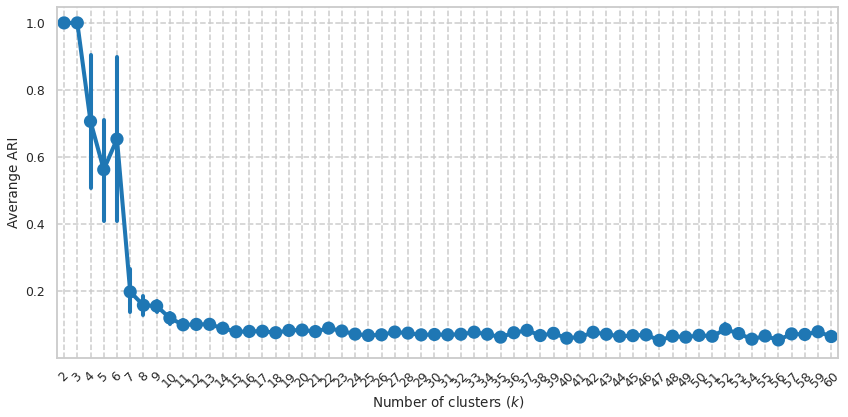

In [49]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(12, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()